## Sentiment Data EDA

In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import re

In [30]:
df=pd.read_csv('data/Sentiment140.csv', encoding='latin-1', header=None, index_col=False)
df = df[[0, 5]].rename(columns={0: "target", 5: "text"})
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [31]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [32]:
# output the dataframe structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


<AxesSubplot:>

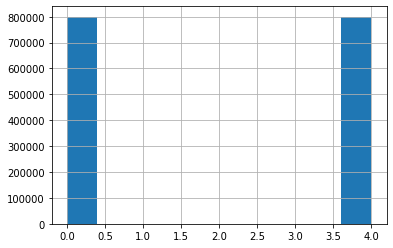

In [33]:
#Convert target to categorical
df['target'] = pd.Categorical(df.target)
df['target'].unique()
df['target'].hist()

In this dataset, target values describe the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive). However, there are only negative and positive tags (0 and 4) so let's change those values to 0 = negative, 1 = positive

<AxesSubplot:>

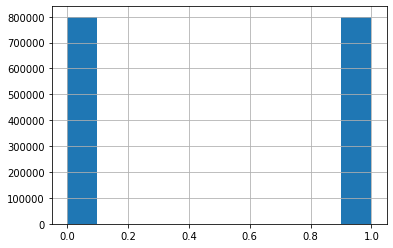

In [34]:
df['target'] = df['target'].replace(4,1) #Replace 4 (positive) by 1. Negative (0) remain the same
df['target'].hist()

<AxesSubplot:>

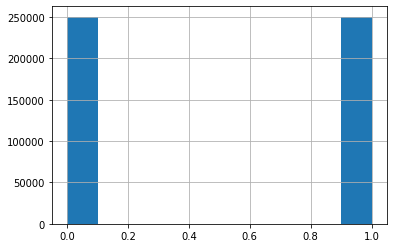

In [35]:
#For testing purposes, get a sample of the data
df=df.sample(500000)
df['target'].hist()

## Data Preprocessing Pipeline

In [36]:
def data_cleaning(texts): 
    remove_stop_words = False #TODO set as param
    lemmatizer=WordNetLemmatizer()
    tokenizer=TweetTokenizer()
    clean_text=[]
    for text in texts: 
        text = text.lower() #lowe case
        text = re.sub("\s\s+", " ", text) #remove extra spaces
        text = text.encode('ascii',errors='ignore').decode() #Remove non-ASCII characters
        text = re.sub(r'[0-9]', '', text) #Remove numbers
        lemmatized_tokens=[]
        tokens=tokenizer.tokenize(text.lower())
        for token in tokens:    
            lemmatized_token=lemmatizer.lemmatize(token)
            if remove_stop_words:
                if lemmatized_token not in stopwords.words('english'): lemmatized_tokens.append(lemmatized_token) 
            else: 
                lemmatized_tokens.append(lemmatized_token)
        clean_text.append(' '.join(lemmatized_tokens))
    return clean_text

In [37]:
estimators=[('cleaner', FunctionTransformer(data_cleaning)), #TODO Add stop words param
            ('vectorizer', TfidfVectorizer(max_features=100000, ngram_range=(1, 2)))] #TODO Check these values
preprocessing_pipeline=Pipeline(estimators)

### Train, Test Split and Preprocessing

In [38]:
# Split in training set and, testing set and separate labels from data
X=df['text']
y=df['target']
X_train, X_test, y_train, y_test=train_test_split(X, y)

In [39]:
#Preprocess the training set
X_train_transformed=preprocessing_pipeline.fit_transform(X_train)
#At 22min fails

In [40]:
#Preprocess test set
X_test_transformed=preprocessing_pipeline.transform(X_test)

## Naive Bayes Model

### Train Model

In [41]:
# Create a Naive Bayes model and fit the training data
naive_bayes_model=MultinomialNB()
naive_bayes_model.fit(X_train_transformed, y_train)

MultinomialNB()

### Evaluate Model

In [42]:
# Evaluate model
print(f'Test Score: {naive_bayes_model.score(X_test_transformed, y_test)}')
print(f'Train Score: {naive_bayes_model.score(X_train_transformed, y_train)}')

Test Score: 0.795304
Train Score: 0.829408


## Hate Speech Detection with Naive Bayes Model

### Hate Speech Data Preprocessing

In [95]:
df_hate=pd.read_csv('data/HateSpeech_tweets.csv', encoding='latin-1', usecols  = ["class", "tweet"])
df_hate = df_hate.rename(columns={"class": "target", "tweet": "text"})
df_hate.head()

,target,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [44]:
df_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  24783 non-null  int64 
 1   text    24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [45]:
df_hate.isnull().sum()

target    0
text      0
dtype: int64

<AxesSubplot:>

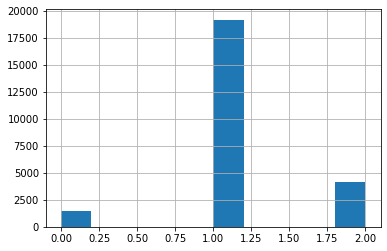

In [96]:
#Convert target to categorical
df_hate['target'] = pd.Categorical(df_hate.target)
df_hate['target'].unique()
df_hate['target'].hist()

UPDATE THIS IF WE ARE FINALLY KEEPING NON_OFFENSIVE TWEETS
In this dataset, target values describe the type of the tweet (0 - hate speech, 1 - offensive language, 2 - neither). However, for the desired task we are only interested in retrieving the hate speech and offensive language and identify a Negative Sentiment. Thus, we will remove the non-offensive text rows (tagged as 2-neither) and combine hate speech (0) and offensive language (1) into the same category 0, which is the value we used when traning the model to tag a Negative sentiment.

<AxesSubplot:>

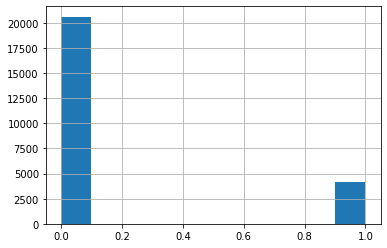

In [97]:
df_hate['target'] = df_hate['target'].replace(1,0) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
df_hate['target'] = df_hate['target'].replace(2,1) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
#df_hate = df_hate[df_hate['target'] == 0] #Keep only the rows with hate/offensive tweets
df_hate['target'].hist()

In [98]:
# Split text from labels
X=df_hate['text']
y=df_hate['target']

In [99]:
#Preprocess data
X_transformed=preprocessing_pipeline.transform(X)

### Apply Naive Bayes Model to Hate Speech data

In [100]:
#Evaluate model on hate speech
print(f'Score: {naive_bayes_model.score(X_transformed, y)}')

Score: 0.5075656700157366


## VADER on Hate Speech Data

In [88]:
import pandas as pd
from sklearn.metrics import accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt

According to the academic paper on VADER, the Valence score is measured on a scale from -4 to +4, where -4 stands for the most 'Negative' sentiment and +4 for the most 'Positive' sentiment. Let's set the following ranges for defining the polarity of the text:

- From -4 to 0: Negative --> 0
- From 0 to 4: Positive --> 1

In [101]:
analyzer = SentimentIntensityAnalyzer()

In [102]:
df_vader = df_hate #Make copy
df_vader['vader']=df_vader.apply(lambda x: analyzer.polarity_scores(x['text'])['compound'], axis=1)
df_vader.head()

,target,text,vader
0,1,!!! RT @mayasolovely: As a woman you shouldn't...,0.4563
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,-0.6876
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,-0.9550
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0.5673
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0.6331


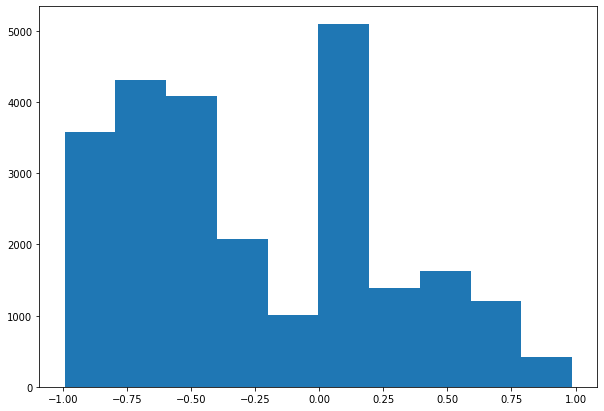

In [103]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(df_vader['vader'])
plt.show()

In [104]:
#Translate polarity into 0-Negative or 1-Other
df_vader['predicted_target']=df_vader.apply(lambda x: 0 if x['vader'] <= 0 else 1, axis=1)
df_vader.head()

,target,text,vader,predicted_target
0,1,!!! RT @mayasolovely: As a woman you shouldn't...,0.4563,1
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,-0.6876,0
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,-0.9550,0
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0.5673,1
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0.6331,1


In [105]:
# Evaluate results
print(f'Accuracy: {accuracy_score(df_vader.dropna()["target"].values, df_vader.dropna()["predicted_target"].values)}')

Accuracy: 0.7401041036194166
